In [1]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [2]:
!git clone https://github.com/D2DOnline/FaceRecognition1.git

Cloning into 'FaceRecognition1'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 94 (delta 26), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [3]:
!ls FaceRecognition1


data-preprocess.py  main.ipynb	README.md  test-images	train-images


In [4]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

Using TensorFlow backend.


In [5]:
def extract_face(filename, required_size=(160, 160)):
	image = Image.open(filename)
	image = image.convert('RGB')
	pixels = asarray(image)
	detector = MTCNN()
	results = detector.detect_faces(pixels)
	x1, y1, width, height = results[0]['box']
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	face = pixels[y1:y2, x1:x2]
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

In [6]:
def load_faces(directory):
	faces = list()
	for filename in listdir(directory):
		path = directory + '/' + filename
		face = extract_face(path)
		faces.append(face)
	return faces

In [7]:
def load_dataset(directory):
	X, y = list(), list()
	for subdir in listdir(directory):
		path = directory + '/' + subdir
		if not isdir(path):
			continue
		faces = load_faces(path)
		labels = [subdir for _ in range(len(faces))]
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)


In [8]:
trainX, trainY = load_dataset('FaceRecognition1/train-images')
print(trainX.shape, trainY.shape)
testX, testY = load_dataset('FaceRecognition1/test-images')
savez_compressed('FaceRecognition1/face-dataset.npz', trainX, trainY, testX, testY)

>loaded 8 examples for class: anand
>loaded 8 examples for class: guru
>loaded 8 examples for class: jitendra
(24, 160, 160, 3) (24,)
>loaded 4 examples for class: anand
>loaded 3 examples for class: guru
>loaded 3 examples for class: jitendra


In [9]:
!ls FaceRecognition1

data-preprocess.py  main.ipynb	test-images
face-dataset.npz    README.md	train-images


In [10]:
from google.colab import files
uploaded=files.upload()

Saving facenet_keras.h5 to facenet_keras.h5


In [11]:
!ls 


facenet_keras.h5  FaceRecognition1  sample_data


In [12]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('FaceRecognition1/face-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('FaceRecognition1/face-dataset_embeding.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (24, 160, 160, 3) (24,) (10, 160, 160, 3) (10,)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(24, 128)
(10, 128)


In [14]:
!ls FaceRecognition1/


data-preprocess.py	   face-dataset.npz  README.md	  train-images
face-dataset_embeding.npz  main.ipynb	     test-images


In [16]:
from google.colab import files
downloaded=files.download("FaceRecognition1/face-dataset.npz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('FaceRecognition1/face-dataset_embeding.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=24, test=10
Accuracy: train=100.000, test=90.000


Predicted: anand (74.665)
Expected: anand


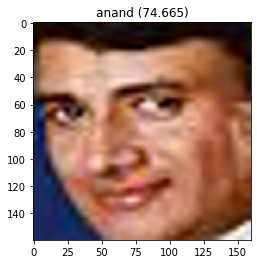

In [18]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('FaceRecognition1/face-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('FaceRecognition1/face-dataset_embeding.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()